<h6>This project aims to predict the Consumer Price Index for All Urban Consumers (CPI-U) in the United States by leveraging various economic indicators. The CPI is a crucial measure of inflation, reflecting changes in the cost of living over time. By accurately forecasting CPI movements, policymakers, economists, and businesses can make informed decisions about monetary policy, budgeting, and investment strategies.</h6>
<h6>The <b>Consumer Price Index For All Urban Consumers (CPI-U)</b> measures the monthly change in consumer prices for a representative basket of goods and services. This metric measures inflation and is an indicator of the effectiveness of government fiscal and monetary policies.<br>
The <b>Unemployment Rate</b> represents the number of unemployed as a percentage of the labor force. Labor force data are restricted to people 16 years of age and older, who currently reside in 1 of the 50 states or the District of Columbia, who do not reside in institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.<br>
The <b>Labor Force Participation Rate</b> is defined by the Current Population Survey (CPS) as the number of people in the labor force as a percentage of the civilian noninstitutional population. The participation rate is the percentage of the population that is either working or actively looking for work.<br>
The <b>Treasury and Agency Securities, All Commercial Banks</b> refers to a specific economic indicator tracked by the Federal Reserve Economic Data (FRED). This indicator represents the total amount of U.S. Treasury and agency securities held by all commercial banks in the United States. Monitoring the trends in Treasury and agency securities held by commercial banks can provide insights into the liquidity and risk appetite of banks, as well as broader trends in the financial markets and the economy as a whole.
</h6>

<h5>Import Libraries</h5>

In [1]:
# Scientific Computing 
import numpy as np

# Data manipulation and analysis
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV

# Regression Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score, explained_variance_score

# Feature Selection
from sklearn.feature_selection import SelectKBest

# Split data
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import Pipeline

# Decomposition
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Statistics
from statsmodels.tsa.stattools import grangercausalitytests

# Time-related functions
import time

# System and OS
import sys 
import os

sys.path.append(os.path.abspath("../src"))
from data_preprocessing.main import FredApi


['/home/felipe/Documents/tier0/economic-analysis-fred/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/felipe/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/felipe/Documents/tier0/economic-analysis-fred/src']


<h5>Data Collection</h5>
<h6>Obtain the tabular data (.db) from database.</h6>

In [2]:
api_client = FredApi(config_path="../config.yaml")

# Labor Force Participation Rate
df_labor_force = api_client.fetch_and_preprocess_series(series_id="CIVPART")
print(df_labor_force.head(2))
print(df_labor_force.tail(2))

# Unemployment Rate
df_unemployment = api_client.fetch_and_preprocess_series(series_id="unrate")
print(df_unemployment.head(2))
print(df_unemployment.tail(2))

# Treasury and Agency Securities, All Commercial Banks
df_usgsec = api_client.fetch_and_preprocess_series(series_id="USGSEC")
print(df_usgsec.head(2))
print(df_usgsec.tail(2))

# Consumer Price Index for All Urban Consumer (CPI-U)
df_cpi = api_client.fetch_and_preprocess_series(series_id="CPIAUCSL")
print(df_cpi.head(2))
print(df_cpi.tail(2))

        date  value
0 1948-01-01   58.6
1 1948-02-01   58.9
          date  value
912 2024-01-01   62.5
913 2024-02-01   62.5
        date  value
0 1948-01-01    3.4
1 1948-02-01    3.8
          date  value
912 2024-01-01    3.7
913 2024-02-01    3.9
        date    value
0 1947-01-01  74.1247
1 1947-02-01  73.2080
          date      value
924 2024-01-01  4081.5326
925 2024-02-01  4088.0415
        date  value
0 1947-01-01  21.48
1 1947-02-01  21.62
          date    value
924 2024-01-01  309.685
925 2024-02-01  311.054


<h5>Data Cleaning</h5>
<h6>Preprocess the data to handle missing values, outliers, duplicates, and inconsistencies. This ensures that the data is accurate and ready for analysis.</h6></p>

In [3]:
main_df = (
    pd.merge(df_labor_force, df_unemployment, on="date", how="left", suffixes=('_labor', '_unemployment'))
    .merge(df_usgsec, on="date", how="left")
    .merge(df_cpi, on="date", how="left")
    .rename(columns={"value_labor": "labor_force_rate", "value_unemployment": "unemployment_rate", "value_x": "usgsec", "value_y": "cpi"})
)
main_df.set_index("date", inplace=True)
print(main_df)

            labor_force_rate  unemployment_rate     usgsec      cpi
date                                                               
1948-01-01              58.6                3.4    69.8213   23.680
1948-02-01              58.9                3.8    68.7979   23.670
1948-03-01              58.5                4.0    66.8883   23.500
1948-04-01              59.0                3.9    66.5288   23.820
1948-05-01              58.3                3.5    66.4599   24.010
...                      ...                ...        ...      ...
2023-10-01              62.7                3.8  4005.3137  307.531
2023-11-01              62.8                3.7  3998.2957  308.024
2023-12-01              62.5                3.7  4069.8439  308.742
2024-01-01              62.5                3.7  4081.5326  309.685
2024-02-01              62.5                3.9  4088.0415  311.054

[914 rows x 4 columns]


In [4]:
# Analyze the missing values and duplicates in the DataFrame
def analyze_missing_and_duplicates(data: pd.DataFrame) -> pd.DataFrame:
    n = data.shape[0]
    ret = pd.DataFrame(data.isnull().sum(), columns=["missing_number"])
    ret["percentage_missing_number"] = (ret["missing_number"] / n) * 100
    ret["types"] = data.dtypes
    ret["duplicate"] = data.duplicated(keep=False).sum()
    ret["NAN"] = data.isna().sum()
    return pd.DataFrame(ret)


analyze_missing_and_duplicates(main_df)

,missing_number,percentage_missing_number,types,duplicate,NAN
labor_force_rate,0,0.0,float64,0,0
unemployment_rate,0,0.0,float64,0,0
usgsec,0,0.0,float64,0,0
cpi,0,0.0,float64,0,0


<h5>Exploratory Data Analysis (EDA)</h5>
<h6>Perform initial exploration of the data to understand its structure, distribution, and relationships. This involves generating summary statistics, visualizations (e.g., histograms, scatter plots, box plots), and identifying patterns or trends.</h6></p>

In [5]:
print(main_df.info())
main_df.describe().T.style.background_gradient(cmap="Oranges").format("{:.2f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 914 entries, 1948-01-01 to 2024-02-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   labor_force_rate   914 non-null    float64
 1   unemployment_rate  914 non-null    float64
 2   usgsec             914 non-null    float64
 3   cpi                914 non-null    float64
dtypes: float64(4)
memory usage: 35.7 KB
None


,count,mean,std,min,25%,50%,75%,max
labor_force_rate,914.00,62.84,2.92,58.10,59.80,62.90,66.00,67.30
unemployment_rate,914.00,5.70,1.71,2.50,4.40,5.50,6.70,14.80
usgsec,914.00,797.59,1060.34,56.44,68.73,273.54,1155.53,4699.54
cpi,914.00,120.71,85.03,23.50,32.94,109.05,192.22,311.05


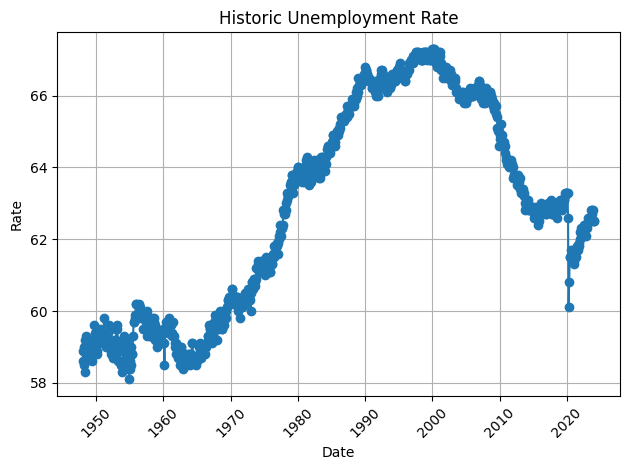

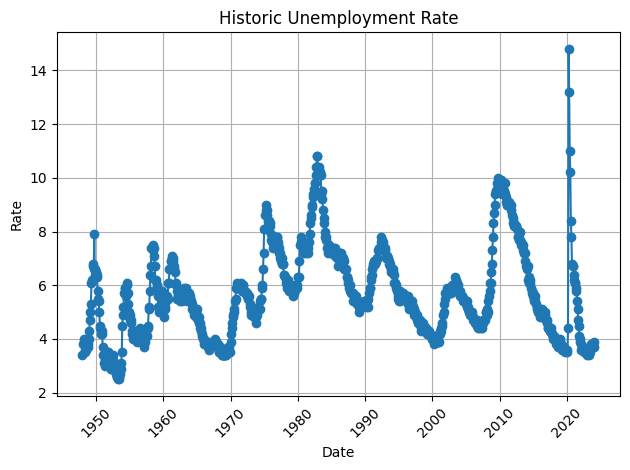

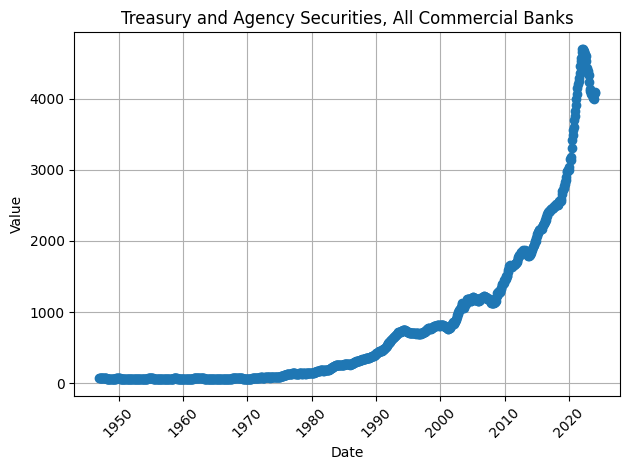

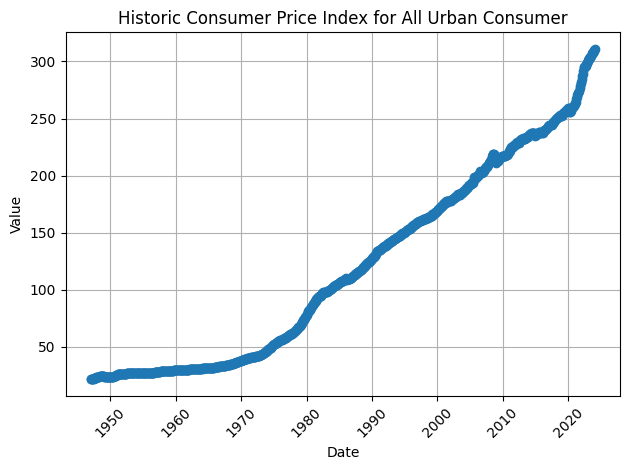

In [6]:
plt.plot(df_labor_force["date"], df_labor_force["value"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.title("Historic Unemployment Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(df_unemployment["date"], df_unemployment["value"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.title("Historic Unemployment Rate")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(df_usgsec["date"], df_usgsec["value"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Treasury and Agency Securities, All Commercial Banks")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(df_cpi["date"], df_cpi["value"], marker="o", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Historic Consumer Price Index for All Urban Consumer")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<h6>Heatmap showing the correlation matrix between CPI-U and the economic indicators, helping identify which indicators have the strongest correlation with CPI-U, aiding in feature selection for modeling.</h6>

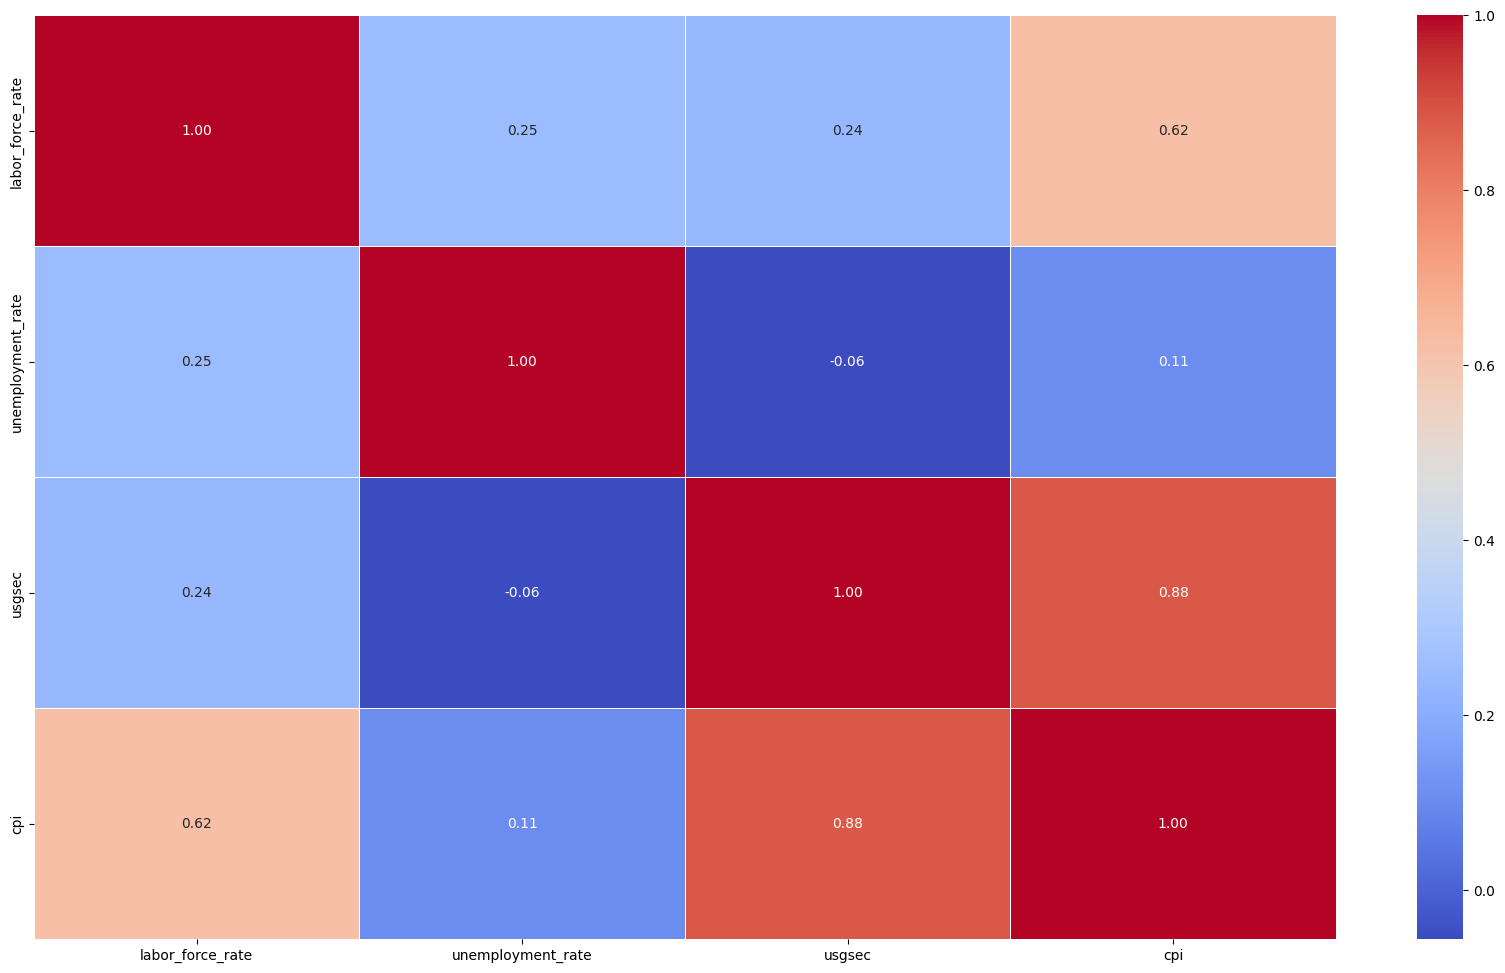

In [7]:
df_corr = main_df[main_df.columns].dropna().corr()
plt.figure(figsize=(21, 12))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.savefig("../reports/correlation_matrix.png")
plt.show()

<h6>Created distribution plots for each economic indicator to visualize their distributions and identify any outliers or skewness in the data.</h6>

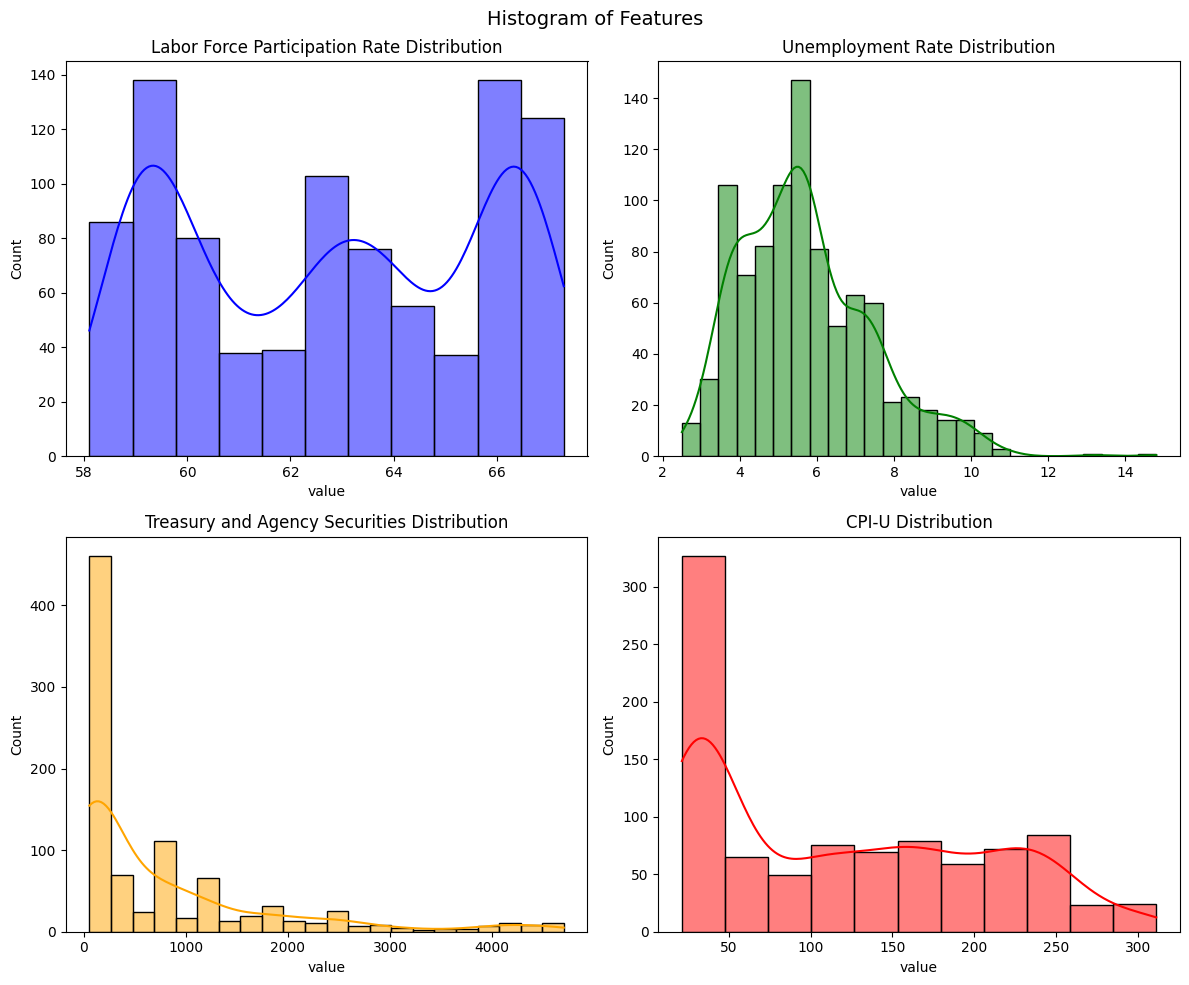

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Distribution plots for each economic indicator
sns.histplot(df_labor_force["value"], kde=True, ax=axes[0], color="blue")
axes[0].set_title("Labor Force Participation Rate Distribution")

sns.histplot(df_unemployment["value"], kde=True, ax=axes[1], color="green")
axes[1].set_title("Unemployment Rate Distribution")

sns.histplot(df_usgsec["value"], kde=True, ax=axes[2], color="orange")
axes[2].set_title("Treasury and Agency Securities Distribution")

sns.histplot(df_cpi["value"], kde=True, ax=axes[3], color="red")
axes[3].set_title("CPI-U Distribution")

plt.suptitle("Histogram of Features", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

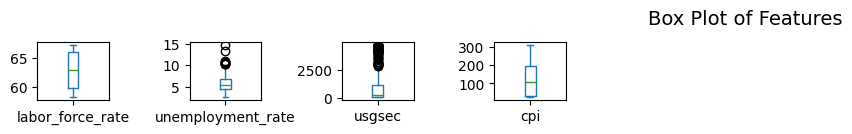

In [9]:
plt.figure(figsize=(12, 8), facecolor="lightgrey")
main_df.plot(kind="box", layout=(10, 10), subplots=True, sharex=False, sharey=False, figsize=(15, 10))
plt.suptitle("Box Plot of Features", fontsize=14)
plt.tight_layout()
plt.show()

<h6>Ploted the historical trend of CPI-U alongside each economic indicator (Unemployment Rate, Labor Force Participation Rate, Treasury and Agency Securities, All Commercial Banks Data) over time. This help visualize any potential correlations or trends between the CPI-U and these indicators.</h6>

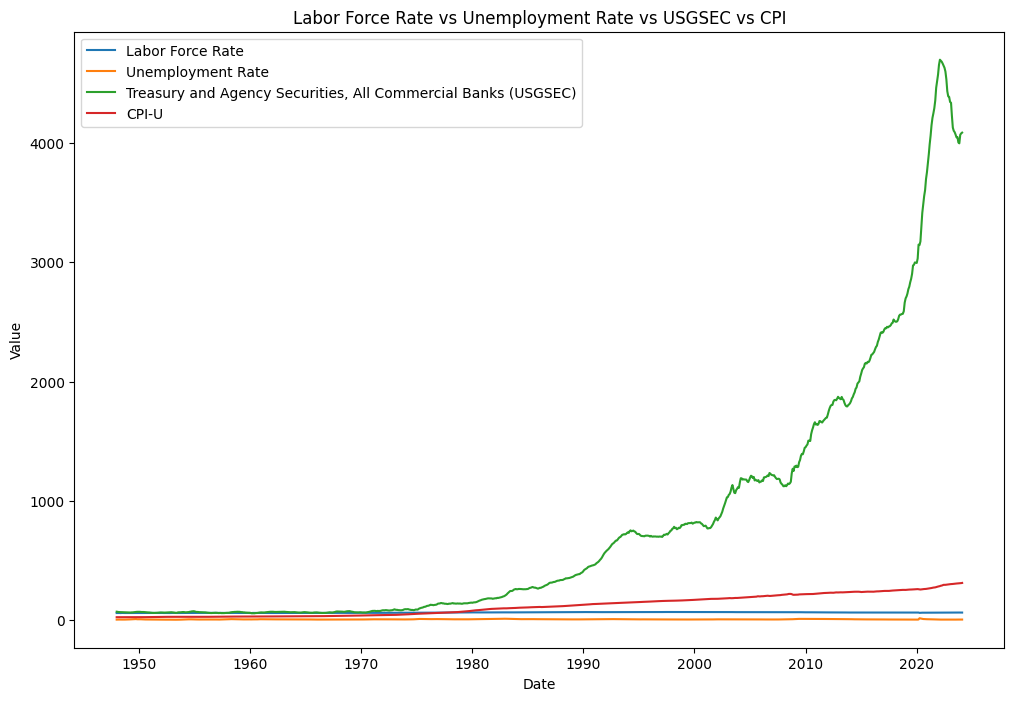

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(main_df.index, main_df["labor_force_rate"], label="Labor Force Rate")
plt.plot(main_df.index, main_df["unemployment_rate"], label="Unemployment Rate")
plt.plot(main_df.index, main_df["usgsec"], label="Treasury and Agency Securities, All Commercial Banks (USGSEC)")
plt.plot(main_df.index, main_df["cpi"], label="CPI-U")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Labor Force Rate vs Unemployment Rate vs USGSEC vs CPI")
plt.legend()
plt.savefig("../reports/time_series.png")
plt.show()

<h6><b>Granger causality test</b> is a statistical hypothesis test for determining whether one time series is useful in forecasting another. It's commonly used in econometrics to investigate causal relationships between variables.</h6>

In [11]:
cpi_unemployment_rate = np.column_stack((main_df["cpi"], main_df["unemployment_rate"]))

# Perform Granger causality test
test_result = grangercausalitytests(cpi_unemployment_rate, maxlag=7, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0092  , p=0.9238  , df_denom=910, df_num=1
ssr based chi2 test:   chi2=0.0092  , p=0.9237  , df=1
likelihood ratio test: chi2=0.0092  , p=0.9237  , df=1
parameter F test:         F=0.0092  , p=0.9238  , df_denom=910, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3523  , p=0.7032  , df_denom=907, df_num=2
ssr based chi2 test:   chi2=0.7084  , p=0.7017  , df=2
likelihood ratio test: chi2=0.7081  , p=0.7018  , df=2
parameter F test:         F=0.3523  , p=0.7032  , df_denom=907, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7545  , p=0.5199  , df_denom=904, df_num=3
ssr based chi2 test:   chi2=2.2810  , p=0.5162  , df=3
likelihood ratio test: chi2=2.2781  , p=0.5167  , df=3
parameter F test:         F=0.7545  , p=0.5199  , df_denom=904, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6754  , p=0.6091  

/home/felipe/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


<h5>Feature Engineering</h5>
<h6>The feature engineering step adds three new features ('labor_force_rate_log', 'unemployment_rate_log' and 'usgsec_log') based on the 'labor_force_rate', 'unemployment_rate' and 'usgsec' column to help in the analysis.</h6>

In [12]:
class FeatureEngineering:
    # A class to perform feature engineering on the input data.
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X):
        # Location Features
        X["labor_force_rate_log"] = np.log(X["labor_force_rate"])
        X["unemployment_rate_log"] = np.log(X["unemployment_rate"])
        X["usgsec_log"] = np.log(X["usgsec"])

        return pd.DataFrame(X)

df = FeatureEngineering().fit_transform(main_df)

print(main_df.columns, df.columns)
print(main_df.shape, df.shape)
main_df.head()

Index(['labor_force_rate', 'unemployment_rate', 'usgsec', 'cpi',
       'labor_force_rate_log', 'unemployment_rate_log', 'usgsec_log'],
      dtype='object') Index(['labor_force_rate', 'unemployment_rate', 'usgsec', 'cpi',
       'labor_force_rate_log', 'unemployment_rate_log', 'usgsec_log'],
      dtype='object')
(914, 7) (914, 7)


,labor_force_rate,unemployment_rate,usgsec,cpi,labor_force_rate_log,unemployment_rate_log,usgsec_log
date,,,,,,,
1948-01-01,58.6,3.4,69.8213,23.68,4.070735,1.223775,4.245939
1948-02-01,58.9,3.8,68.7979,23.67,4.075841,1.335001,4.231173
1948-03-01,58.5,4.0,66.8883,23.50,4.069027,1.386294,4.203024
1948-04-01,59.0,3.9,66.5288,23.82,4.077537,1.360977,4.197635
1948-05-01,58.3,3.5,66.4599,24.01,4.065602,1.252763,4.196599


<h5>Splitting the dataset</h5>

In [13]:
X = main_df.drop(["cpi"], axis=1)
y = main_df["cpi"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train -> {X_train.describe()}\nTest -> {X_test.describe()}")

Train ->        labor_force_rate  unemployment_rate       usgsec  labor_force_rate_log  \
count        731.000000         731.000000   731.000000            731.000000   
mean          62.858550           5.737346   792.805457              4.139803   
std            2.924679           1.698255  1028.256143              0.046631   
min           58.100000           2.500000    56.443000              4.062166   
25%           59.800000           4.450000    68.769250              4.091006   
50%           62.900000           5.500000   280.039400              4.141546   
75%           66.000000           6.800000  1166.036000              4.189655   
max           67.300000          14.800000  4691.127700              4.209160   

       unemployment_rate_log  usgsec_log  
count             731.000000  731.000000  
mean                1.705145    5.772748  
std                 0.288919    1.421972  
min                 0.916291    4.033231  
25%                 1.492841    4.230757  
50%

<h5>Feature Selection</h5>

<h6>The feature importance ranking to show which economic indicators have the most significant impact on predicting CPI-U.</h6>

                   Specs        Score
0       labor_force_rate    84.926452
1      unemployment_rate     7.766473
2                 usgsec  3239.590409
3   labor_force_rate_log    76.129579
4  unemployment_rate_log     4.456816
5             usgsec_log  2048.380071


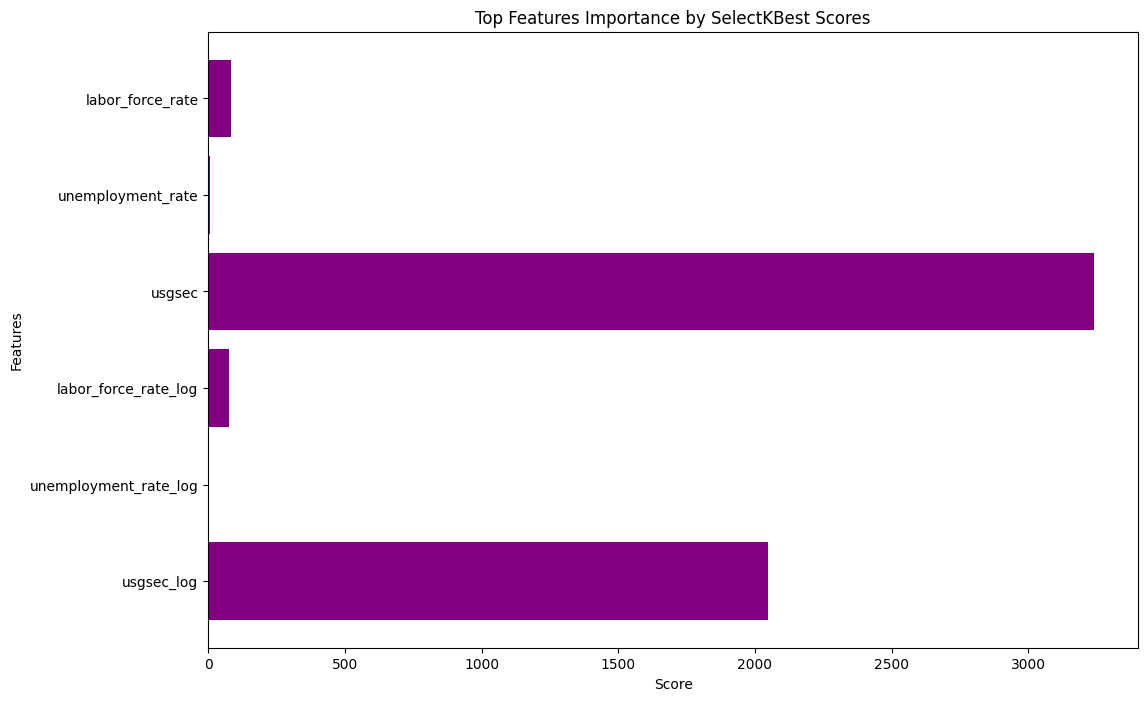

In [14]:
# SelectKBest
select_kbest = SelectKBest(k="all")
fit = select_kbest.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
featureScores = pd.concat([df_columns, df_scores], axis=1)
featureScores.columns = ["Specs", "Score"]
featureScores.nlargest(10, "Score").set_index("Specs")
print(featureScores)

# Plotting the Feature Scores
plt.figure(figsize=(12, 8))
plt.barh(featureScores["Specs"], featureScores["Score"], color="purple")
plt.xlabel("Score")
plt.ylabel("Features")
plt.title("Top Features Importance by SelectKBest Scores")
plt.gca().invert_yaxis()
plt.savefig("../reports/feature_importance.png")
plt.show()


<h5>Model Evaluation and Model Selection</h5>

<h6>Performance metrics such as <b>Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, Mean Squared Logarithmic Error, Median Absolute Error, R-squared and Explained Variance</b> of different predictive models used in the project.</h6>

Linear Regression - R2Score: 0.9930186902434555 - MAE: 5.381384811768506 - MSE: 52.06543074772197 - RMSE: 7.215637930753037 - MSLE: 0.010223441101950169 - MAPE: 7.393238289092439 - Median Absolute Error: 4.333141943234658 - Explained Variance: 0.9930384804336126

Ridge Regression - R2Score: 0.9925869709941201 - MAE: 5.545990134983409 - MSE: 55.28512009865811 - RMSE: 7.43539643184263 - MSLE: 0.010465371959709889 - MAPE: 7.506060248384122 - Median Absolute Error: 4.124557626798492 - Explained Variance: 0.992598104457031

Lasso Regression - R2Score: 0.9923838342021764 - MAE: 5.52307492834054 - MSE: 56.80008003341011 - RMSE: 7.536582782230293 - MSLE: 0.007768673306908322 - MAPE: 6.656708333665093 - Median Absolute Error: 3.9110268339656855 - Explained Variance: 0.9924634640384215

Elastic Net Regression - R2Score: 0.969540299197784 - MAE: 10.126276209113582 - MSE: 227.16331147281403 - RMSE: 15.07193788047224 - MSLE: 0.014286626760271879 - MAPE: 10.267005605412546 - Median Absolute Error: 6

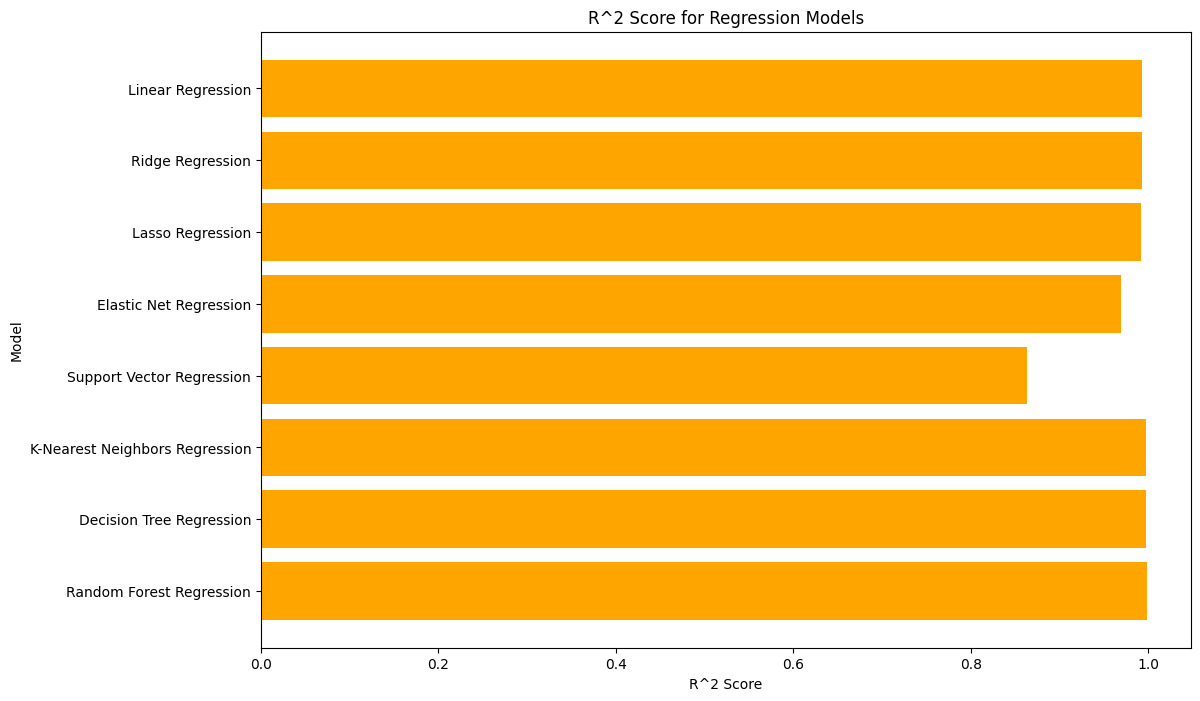

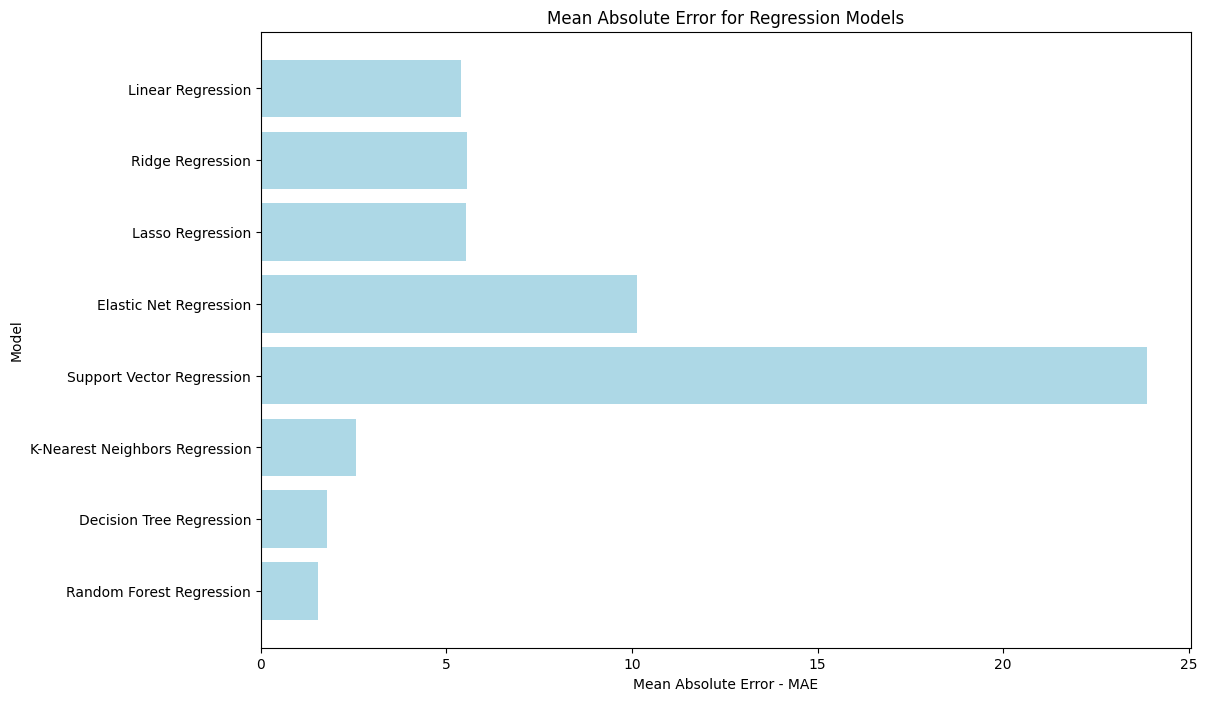

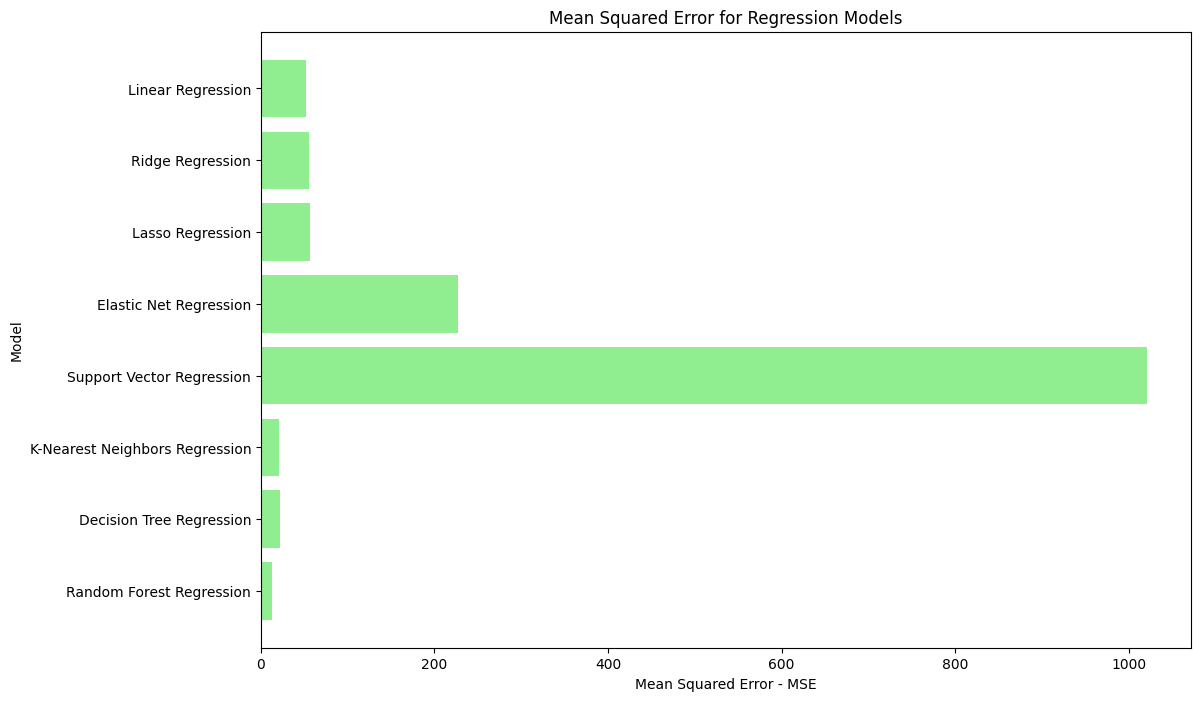

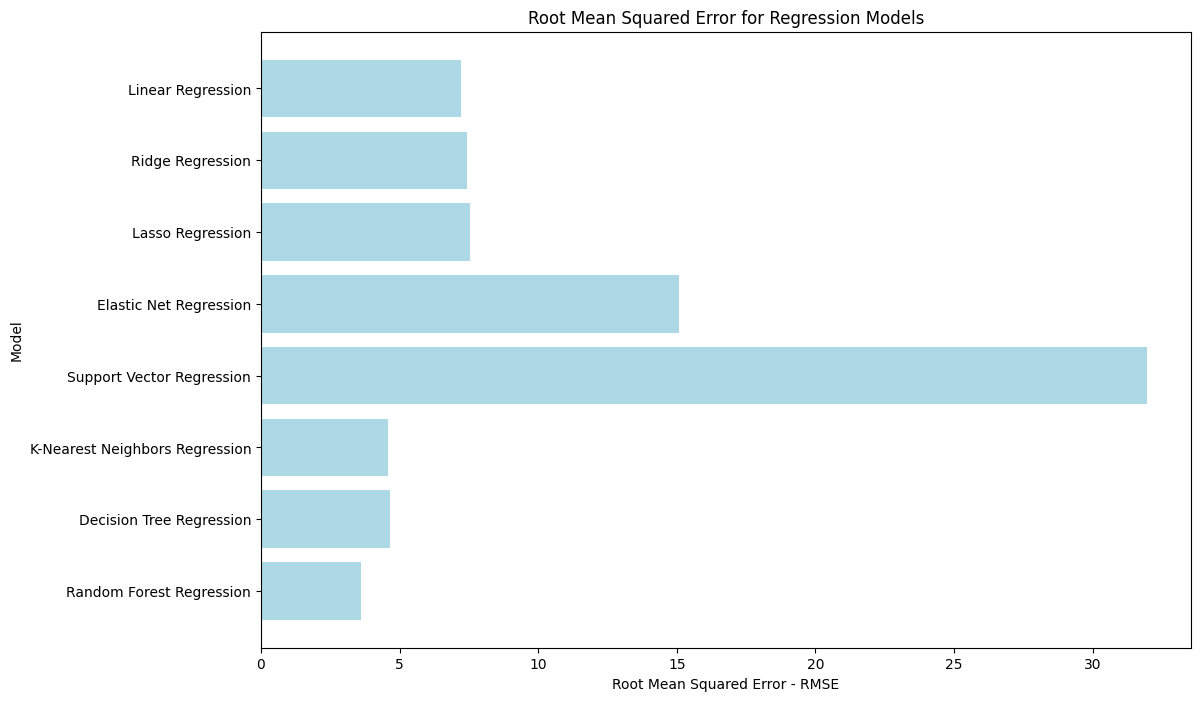

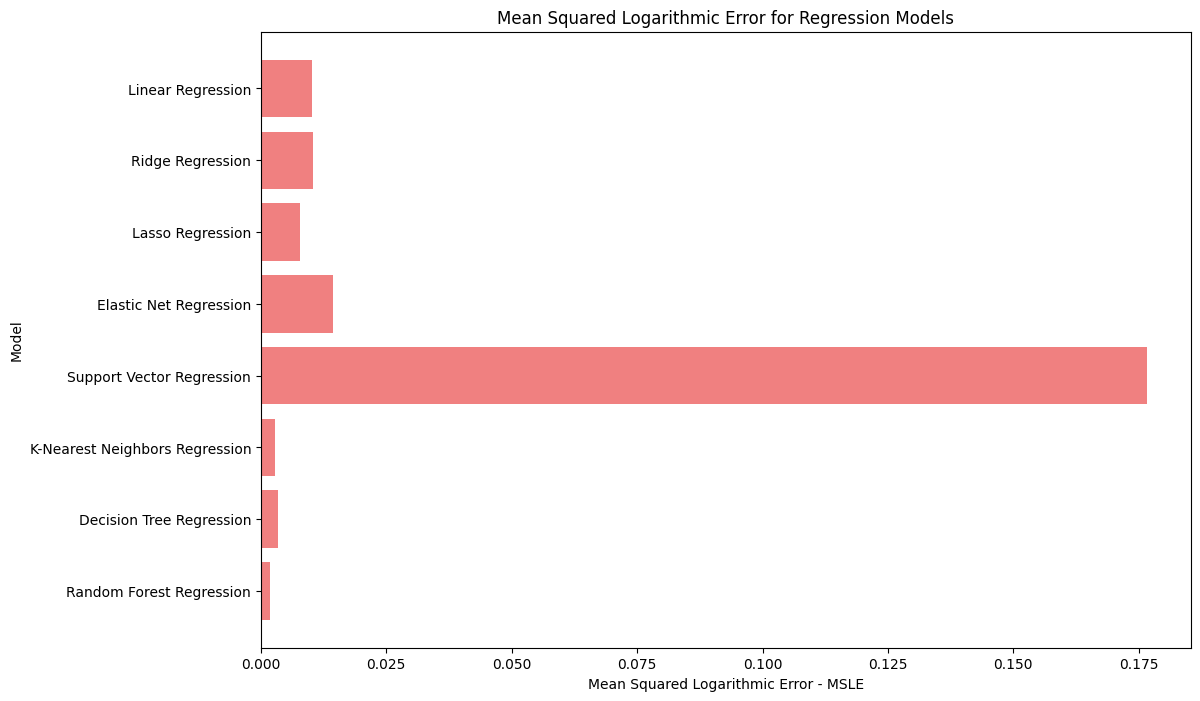

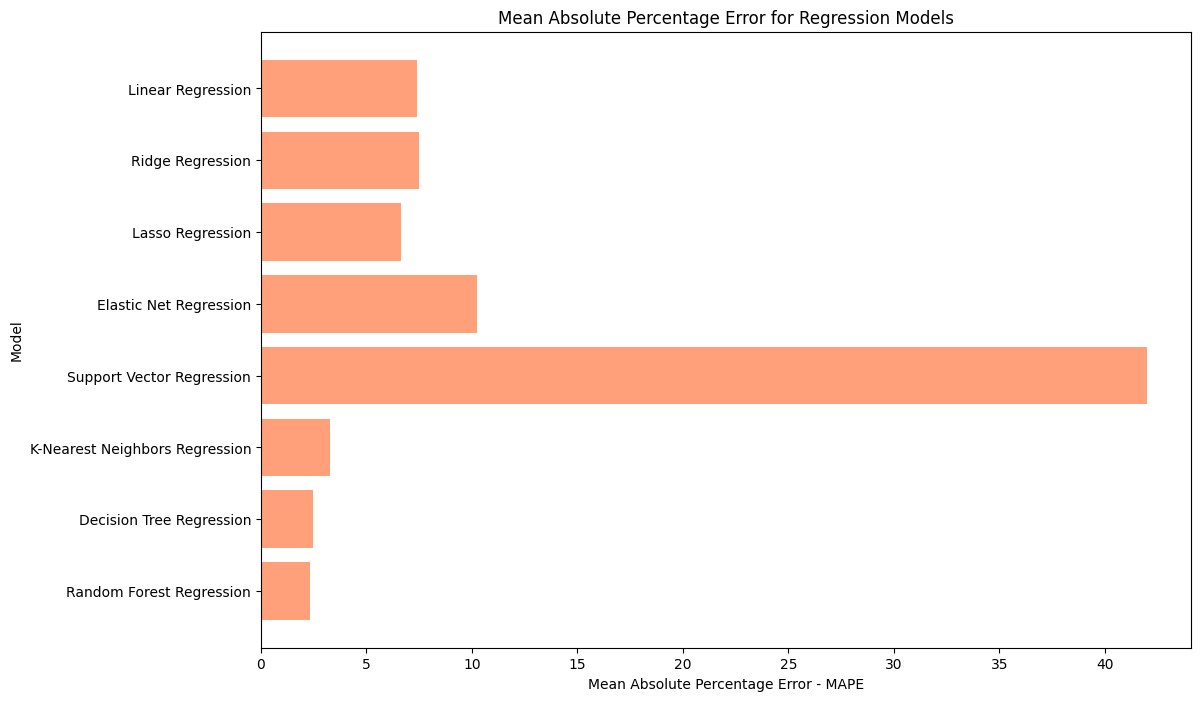

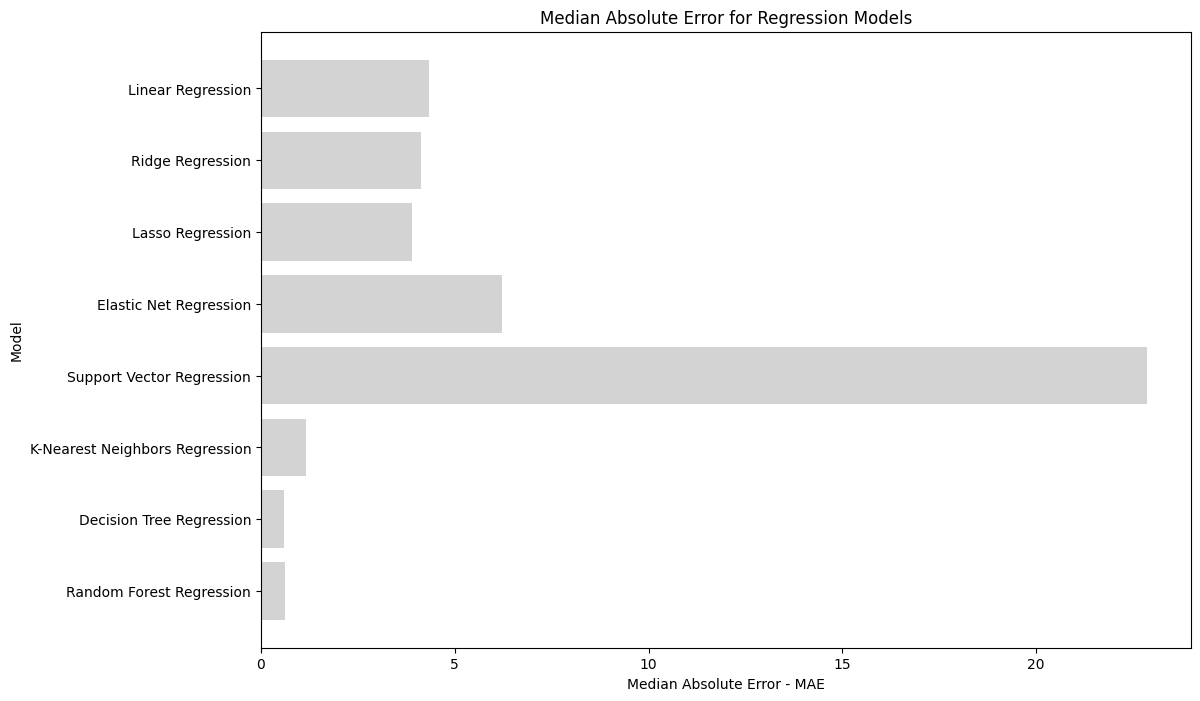

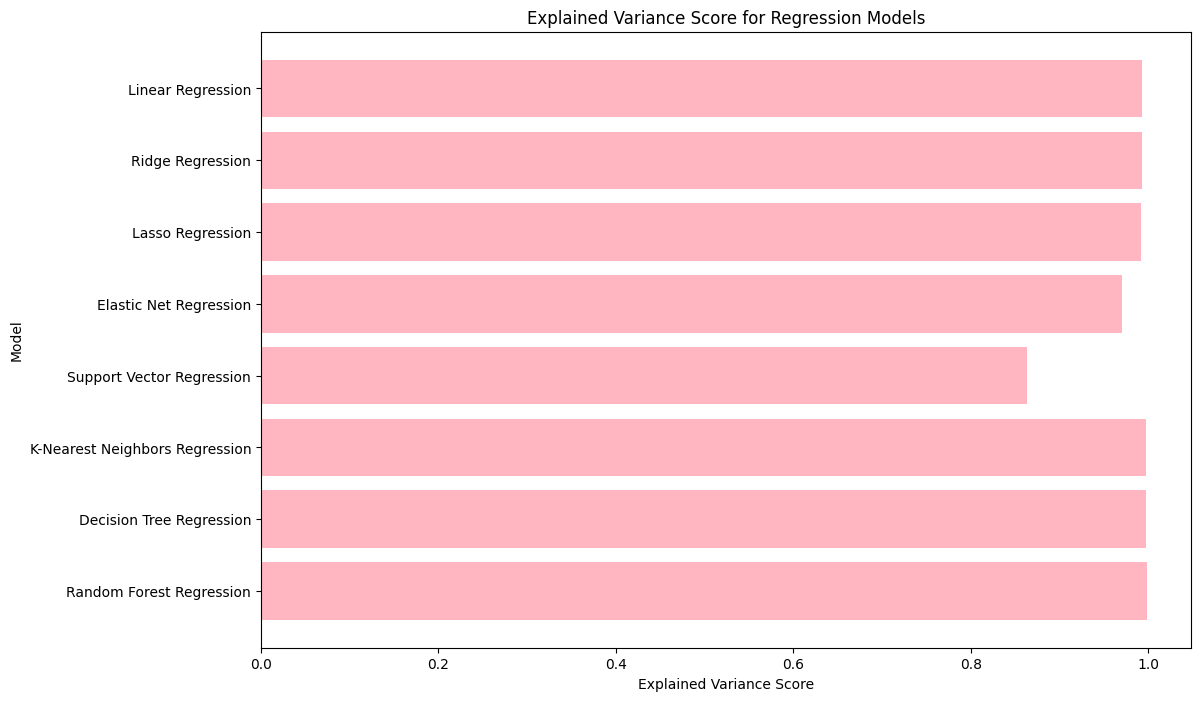

Best model based on R-squared score: Random Forest Regression


In [15]:
# Model Selection of Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors Regression": KNeighborsRegressor(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor()
}

# Dictionary to store regression evaluation scores for each model
mae_scores = {}
r2_scores = {}
mse_scores = {}
rmse_scores = {}
msle_scores = {}
mape_scores = {}
median_absolute_scores = {}
explained_variance_scores = {}
evaluation_scores = {}

# Loop through each regression model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_predictions)
    mae = mean_absolute_error(y_test, y_predictions)
    mse = mean_squared_error(y_test, y_predictions)
    rmse = mean_squared_error(y_test, y_predictions, squared=False)
    msle = mean_squared_log_error(y_test, y_predictions)
    mape = np.mean(np.abs((y_test - y_predictions) / y_test)) * 100
    median_absolute = median_absolute_error(y_test, y_predictions)
    explained_variance = explained_variance_score(y_test, y_predictions)
    
    # Store evaluation metrics in dictionaries
    r2_scores[name] = r2
    mae_scores[name] = mae
    mse_scores[name] = mse
    rmse_scores[name] = rmse
    msle_scores[name] = msle
    mape_scores[name] = mape
    median_absolute_scores[name] = median_absolute
    explained_variance_scores[name] = explained_variance

    # Store evaluation scores
    evaluation_scores[name] = {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Mean Squared Logarithmic Error": msle,
        "Median Absolute Error": median_absolute,
        "R-squared": r2,
        "Explained Variance": explained_variance
    }
    
    # Print scores
    print(f"{name} - R2Score: {r2} - MAE: {mae} - MSE: {mse} - RMSE: {rmse} - MSLE: {msle} - MAPE: {mape} - Median Absolute Error: {median_absolute} - Explained Variance: {explained_variance}\n")


# Plotting the R^2 scores
plt.figure(figsize=(12, 8))
plt.barh(list(r2_scores.keys()), list(r2_scores.values()), color="orange")
plt.xlabel("R^2 Score")
plt.ylabel("Model")
plt.title("R^2 Score for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

# Plotting the Mean Absolute Error scores
plt.figure(figsize=(12, 8))
plt.barh(list(mae_scores.keys()), list(mae_scores.values()), color="lightblue")
plt.xlabel("Mean Absolute Error - MAE")
plt.ylabel("Model")
plt.title("Mean Absolute Error for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest error at the top
plt.show()

# Plotting the Mean Squared Error scores
plt.figure(figsize=(12, 8))
plt.barh(list(mse_scores.keys()), list(mse_scores.values()), color="lightgreen")
plt.xlabel("Mean Squared Error - MSE")
plt.ylabel("Model")
plt.title("Mean Squared Error for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest error at the top
plt.show()

# Plotting the Root Mean Squared Error scores
plt.figure(figsize=(12, 8))
plt.barh(list(rmse_scores.keys()), list(rmse_scores.values()), color="lightblue")
plt.xlabel("Root Mean Squared Error - RMSE")
plt.ylabel("Model")
plt.title("Root Mean Squared Error for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest error at the top
plt.show()

# Plotting the Mean Squared Logarithmic Error scores
plt.figure(figsize=(12, 8))
plt.barh(list(msle_scores.keys()), list(msle_scores.values()), color="lightcoral")
plt.xlabel("Mean Squared Logarithmic Error - MSLE")
plt.ylabel("Model")
plt.title("Mean Squared Logarithmic Error for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest error at the top
plt.show()

# Plotting the Mean Absolute Percentage Error scores
plt.figure(figsize=(12, 8))
plt.barh(list(mape_scores.keys()), list(mape_scores.values()), color="lightsalmon")
plt.xlabel("Mean Absolute Percentage Error - MAPE")
plt.ylabel("Model")
plt.title("Mean Absolute Percentage Error for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest error at the top
plt.show()

# Plotting the Median Absolute Error scores
plt.figure(figsize=(12, 8))
plt.barh(list(median_absolute_scores.keys()), list(median_absolute_scores.values()), color="lightgray")
plt.xlabel("Median Absolute Error - MAE")
plt.ylabel("Model")
plt.title("Median Absolute Error for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest error at the top
plt.show()

# Plotting the Explained Variance Score
plt.figure(figsize=(12, 8))
plt.barh(list(explained_variance_scores.keys()), list(explained_variance_scores.values()), color="lightpink")
plt.xlabel("Explained Variance Score")
plt.ylabel("Model")
plt.title("Explained Variance Score for Regression Models")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

best_model = max(evaluation_scores, key=lambda x: evaluation_scores[x]["R-squared"])
print(f"Best model based on R-squared score: {best_model}")


<h5>Hyperparameters Tuning</h5>

In [16]:
def hyperparameters_search_random(classifier, parameters, cv, X_train, y_train):
    randomized_search = RandomizedSearchCV(classifier, parameters, cv=cv, scoring="r2", verbose=0, n_jobs=-1, random_state=82)
    
    start = time.perf_counter()
    randomized_search = randomized_search.fit(X_train, y_train)
    end = time.perf_counter()
    print(f"roc_auc_train: {randomized_search.best_score_} using {randomized_search.best_params_} in {end - start} seconds")
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    
    return best_model, best_params

classifier = RandomForestRegressor()
parameters = {
    "criterion": ["mse", "mae"],
    "n_estimators": [25, 50, 100, 150],
    "max_depth": range(2, 20, 2),
    "min_samples_leaf": [25, 50, 100, 150, 200]
}

best_rf, best_parameters = hyperparameters_search_random(classifier, parameters, cv=10, X_train=X_train, y_train=y_train)
print(best_rf)
print(best_parameters)

roc_auc_train: 0.9914372217862049 using {'n_estimators': 100, 'min_samples_leaf': 25, 'max_depth': 8, 'criterion': 'mae'} in 11.659442705999936 seconds
RandomForestRegressor(criterion='mae', max_depth=8, min_samples_leaf=25)
{'n_estimators': 100, 'min_samples_leaf': 25, 'max_depth': 8, 'criterion': 'mae'}


<h5>Model Building and Training</h5>

In [17]:
# Create a pipeline with preprocessing and RandomForestRegressor
pipeline = Pipeline(steps=[("scaler", MinMaxScaler()), ("pca", PCA(n_components=0.95)), ("regressor", RandomForestRegressor(**best_parameters))])
pipeline.fit(X_train, y_train)
y_predictions = pipeline.predict(X_test)

<h6>As I used regression models, was created the residual plots to visualize the difference between predicted CPI-U values and actual CPI-U values. This help assess the model's performance and identify any patterns or outliers in the residuals.</h6>

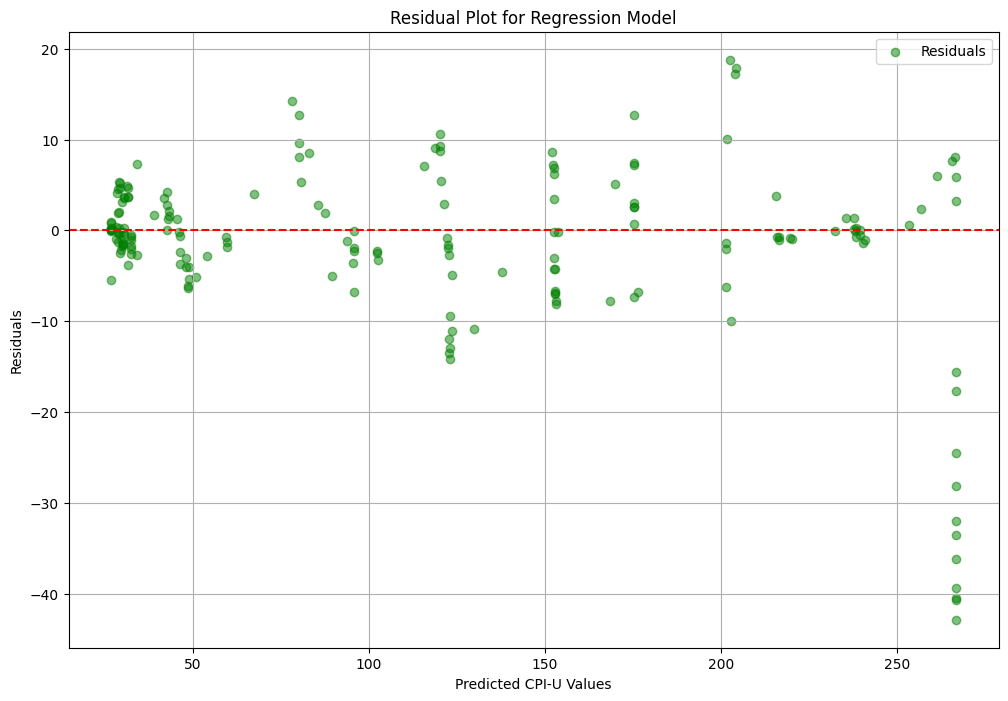

In [18]:

# Calculate residuals by subtracting actual CPI-U values from predicted CPI-U values
residuals = y_predictions - y_test

# Adjusting figure size for better visualization
plt.figure(figsize=(12, 8))
plt.scatter(y_predictions, residuals, color="green", alpha=0.5, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted CPI-U Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Regression Model")
plt.legend()
plt.grid(True)
plt.show()

<h5>Model Evaluation</h5>

In [19]:
# Mean Squared Error - MSE
mse = mean_squared_error(y_test, y_predictions)
print("Mean Squared Error:", mse)

# R-squared score
r2 = r2_score(y_test, y_predictions)
print("R-squared Score:", r2)

Mean Squared Error: 95.6454956517325
R-squared Score: 0.9871751597485403


<h6>Ploted the predicted CPI-U values against the actual CPI-U values over time. This visual representation can demonstrate how well the predictive model captures the actual CPI-U movements.</h6>

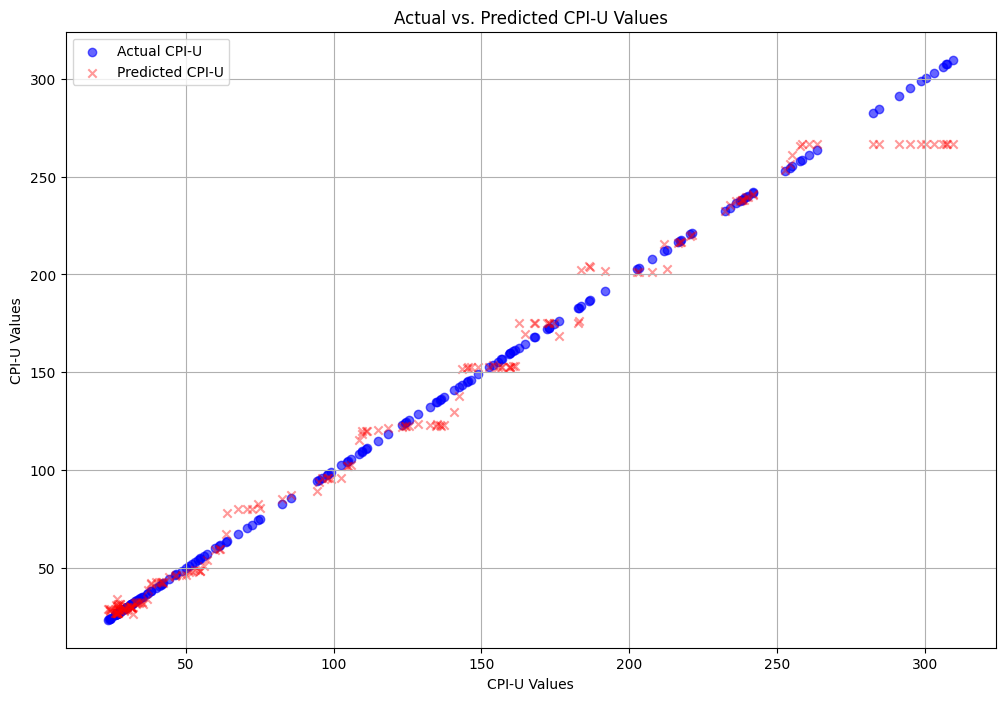

In [20]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_test, color="blue", alpha=0.6, label="Actual CPI-U", marker="o")
plt.scatter(y_test, y_predictions, color="red", alpha=0.4, label="Predicted CPI-U", marker="x")
plt.xlabel("CPI-U Values")
plt.ylabel("CPI-U Values")
plt.title("Actual vs. Predicted CPI-U Values")
plt.legend()
plt.grid(True)
plt.show()

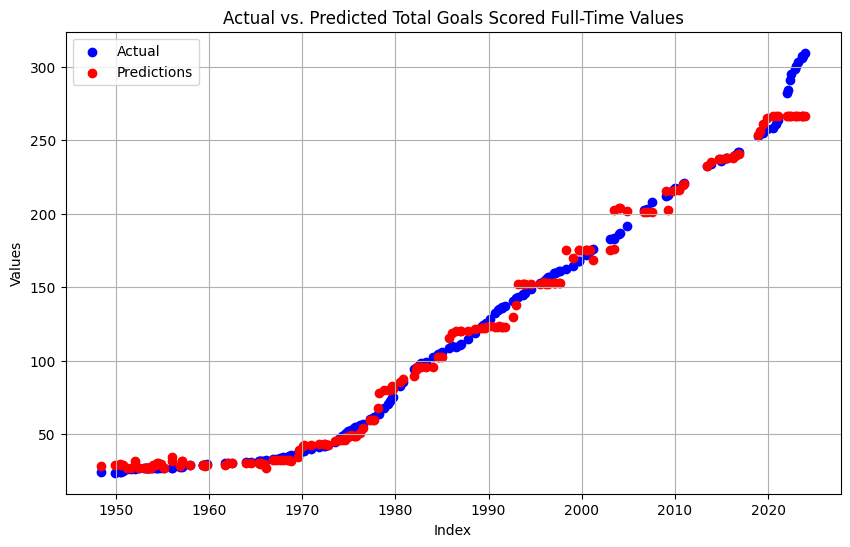

,prediction,actual
date,,
1979-09-01,82.876000,74.400
2019-03-01,256.648325,254.277
1977-08-01,59.765000,61.100
1977-10-01,59.765000,61.600
1978-03-01,67.445000,63.400
...,...,...
1965-07-01,29.889050,31.580
2014-12-01,237.618785,236.252
1996-07-01,152.766500,157.000


In [21]:
# Comparison of predictions and real values, indexed by original indices
comparison_results_df = pd.DataFrame({"prediction": y_predictions, "actual": y_test}, index=y_test.index)

plt.figure(figsize=(10, 6))
plt.scatter(comparison_results_df.index, comparison_results_df["actual"], color="blue", label="Actual")
plt.scatter(comparison_results_df.index, comparison_results_df["prediction"], color="red", label="Predictions")
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Actual vs. Predicted Total Goals Scored Full-Time Values")
plt.legend()
plt.grid(True)
plt.show()

comparison_results_df